<a href="https://colab.research.google.com/github/Vishnu-add/Coding-Raja-Technologies-Internship/blob/main/Image%20Classification%20for%20Food%20Recognition/Image_classification_for_food_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install -q datasets transformers
!sudo apt -qq install git-lfs
!git config --global credential.helper store
!pip install transformers[torch] accelerate>=0.20.1

import os

In [1]:
from huggingface_hub import notebook_login

notebook_login()

## 1) Data Collection

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!unzip "/content/drive/MyDrive/Colab Notebooks/CODING RAJA/Image Classification/archive.zip" -d /tmp/foodimg

Streaming output truncated to the last 5000 lines.
  inflating: /tmp/foodimg/Food Classification/chapati/253.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/254.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/255.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/256.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/257.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/258.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/259.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/260.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/261.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/262.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/263.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/264.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/265.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati/266.jpg  
  inflating: /tmp/foodimg/Food Classification/chapati

In [4]:
from datasets import load_dataset
ds = load_dataset("imagefolder", data_dir="/tmp/foodimg")
ds = ds['train']

Resolving data files:   0%|          | 0/6271 [00:00<?, ?it/s]

In [6]:
data = ds.train_test_split(test_size=0.15)

In [7]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
})

In [9]:
data.push_to_hub("Vishnu-add/indian_food_images")

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

In [8]:
data = load_dataset("Vishnu-add/indian_food_images")

In [9]:
ex = data['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360>,
 'label': 13}

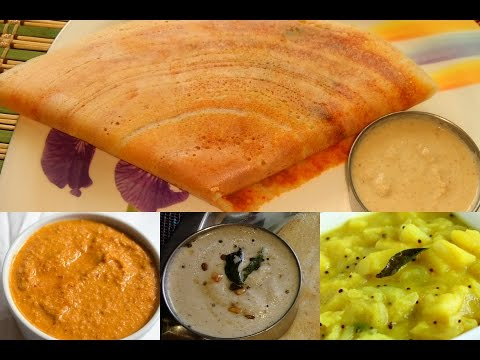

In [10]:
image = ex['image']
image

In [11]:
labels = data['train'].features['label']
labels

ClassLabel(names=['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'], id=None)

In [12]:
labels.int2str(ex['label'])

'masala_dosa'

## 2) Data Preprocessing

In [13]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-13-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [14]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
})

In [15]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

### Preprocessing the data

In [16]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [17]:
width = feature_extractor.size['width']
height = feature_extractor.size['height']
feature_extractor.size


{'height': 224, 'width': 224}

In [18]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((width,height)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((width,height)),
            CenterCrop((width,height)),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [19]:
# split up training into training + validation
train_ds = data['train']
val_ds = data['test']

In [20]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [21]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=650x400>,
 'label': 14,
 'pixel_values': tensor([[[-0.0196, -0.2000, -0.2627,  ...,  0.4431,  0.4275,  0.4118],
          [-0.2157, -0.2627, -0.2549,  ...,  0.4431,  0.4431,  0.4431],
          [-0.2235, -0.2157, -0.2000,  ...,  0.4118,  0.4275,  0.4431],
          ...,
          [-0.2314, -0.2863, -0.3725,  ...,  0.2706,  0.2706,  0.2784],
          [-0.2549, -0.2863, -0.3490,  ...,  0.2549,  0.2627,  0.2863],
          [-0.2784, -0.2941, -0.3333,  ...,  0.2549,  0.2627,  0.2941]],
 
         [[-0.0431, -0.2314, -0.2941,  ...,  0.3255,  0.3255,  0.3176],
          [-0.2314, -0.2863, -0.2784,  ...,  0.3020,  0.3098,  0.3098],
          [-0.2314, -0.2314, -0.2157,  ...,  0.2549,  0.2627,  0.2784],
          ...,
          [-0.4667, -0.4980, -0.5608,  ...,  0.2314,  0.2235,  0.2235],
          [-0.4667, -0.4824, -0.5294,  ...,  0.2078,  0.2078,  0.2157],
          [-0.4745, -0.4824, -0.5059,  ...,  0.2078,  0.2078,  0.2235]

## 3) Model Training

In [22]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    'finetuned-indian-food',
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)#

In [29]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [30]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [31]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [32]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.308300,0.367382,0.913921
200,0.344700,0.291176,0.927736
300,0.375300,0.281749,0.924548
400,0.174200,0.250567,0.931987
500,0.184400,0.251079,0.941552
600,0.179700,0.224926,0.941552


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

events.out.tfevents.1701793181.22fa0422bd56.11071.1:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

events.out.tfevents.1701792918.22fa0422bd56.11071.0:   0%|          | 0.00/8.73k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1538336014GF
  train_loss               =       0.2774
  train_runtime            =   0:15:49.49
  train_samples_per_second =       22.446
  train_steps_per_second   =        0.704


## 4) Model Evaluation

In [33]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9416
  eval_loss               =     0.2249
  eval_runtime            = 0:00:33.73
  eval_samples_per_second =     27.893
  eval_steps_per_second   =      3.498


In [34]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'indian_food_images',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

events.out.tfevents.1701794206.22fa0422bd56.11071.2:   0%|          | 0.00/411 [00:00<?, ?B/s]

## 5) Inference


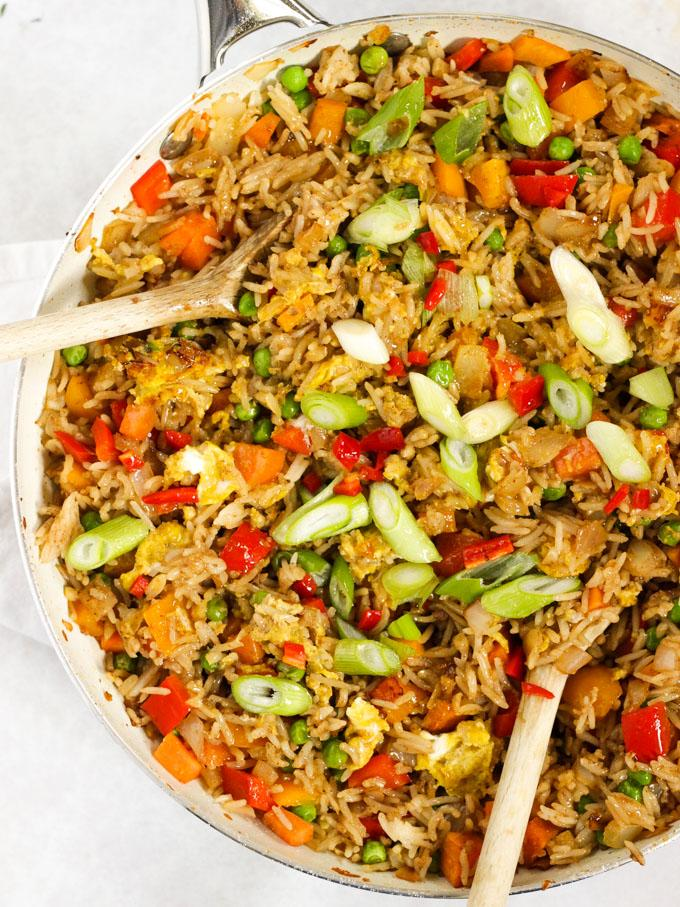

In [37]:
from PIL import Image
import requests
from io import BytesIO

# url = 'https://huggingface.co/Vishnu-add/finetuned-indian-food/resolve/main/126.jpg'
url = 'https://datasets-server.huggingface.co/assets/Vishnu-add/indian_food_images/--/5525ce321b342f4a644a70283b5166df15d6ae9a/--/default/train/1/image/image.jpg'
image = Image.open(BytesIO(requests.get(url, stream=True).content))
image

In [38]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "Vishnu-add/finetuned-indian-food"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

preprocessor_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [39]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [40]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [41]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: fried_rice


## Pipeline API

In [42]:
from transformers import pipeline
pipe = pipeline("image-classification", "Vishnu-add/finetuned-indian-food")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [44]:
url = 'https://datasets-server.huggingface.co/assets/Vishnu-add/indian_food_images/--/5525ce321b342f4a644a70283b5166df15d6ae9a/--/default/train/1/image/image.jpg'
image = Image.open(requests.get(url, stream=True).raw)

pipe(image)

[{'score': 0.9888617396354675, 'label': 'fried_rice'},
 {'score': 0.001356320222839713, 'label': 'chapati'},
 {'score': 0.0008824022370390594, 'label': 'dal_makhani'},
 {'score': 0.0007474644808098674, 'label': 'paani_puri'},
 {'score': 0.0007060692296363413, 'label': 'jalebi'}]

In [45]:
pipe = pipeline("image-classification",
                model=model,
                feature_extractor=feature_extractor)

In [46]:
pipe(image)

[{'score': 0.9888617396354675, 'label': 'fried_rice'},
 {'score': 0.001356320222839713, 'label': 'chapati'},
 {'score': 0.0008824022370390594, 'label': 'dal_makhani'},
 {'score': 0.0007474644808098674, 'label': 'paani_puri'},
 {'score': 0.0007060692296363413, 'label': 'jalebi'}]